# Identify Fraudulent Credit Card Users

### It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### The techniques applied here on one such dataset can help classify such fraudulent transactions 


# Importing libraries

In [1]:
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

%matplotlib inline
plt.style.use('ggplot')

# Importing Credit Card dataset

In [2]:
current_dir = os.getcwd()
path_to_csv = os.path.abspath(os.path.join(current_dir, 'creditcard.csv'))
data = pd.read_csv(path_to_csv)


In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Different types of variables in this dataset are - float64, Int64

In [5]:
data.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


# Identifying duplicate rows and dropping those, if any

In [6]:
print(f"Size of dataframe before dropping duplicate rows - {data.shape[0]}")
data.drop_duplicates(keep=False,inplace=True) 
print(f"Size of dataframe after dropping duplicate rows - {data.shape[0]}")

Size of dataframe before dropping duplicate rows - 284807
Size of dataframe after dropping duplicate rows - 282953


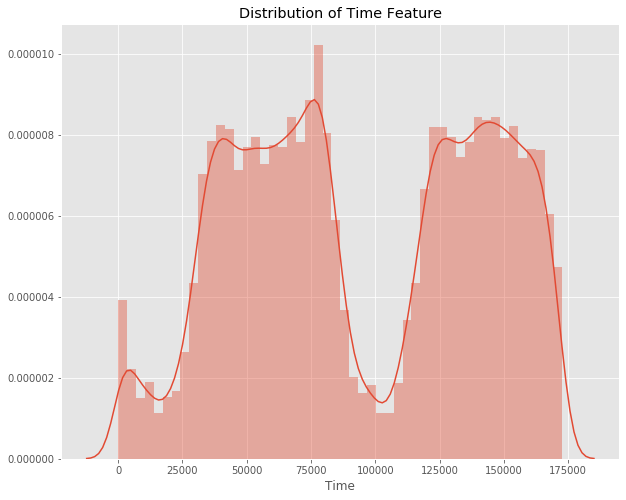

In [7]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.distplot(data.Time)

In [8]:
#fraud vs. normal transactions 
counts = data.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('There were {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%)'.format(normal, perc_normal, fraudulent, perc_fraudulent))

There were 282493 non-fraudulent transactions (99.837%) and 460 fraudulent transactions (0.163%)


Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

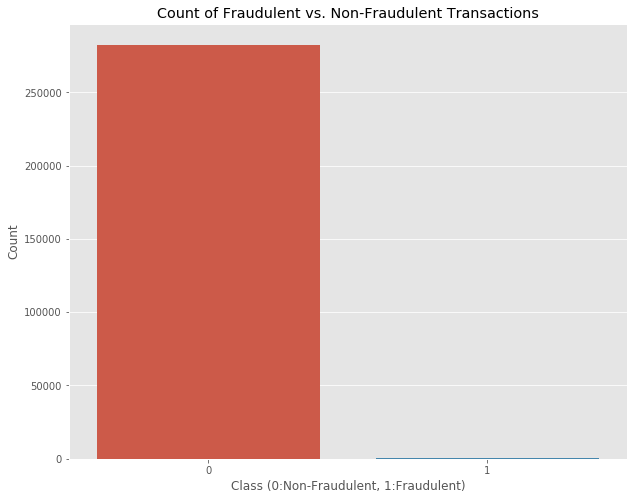

In [9]:
plt.figure(figsize=(10,8))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

## Training our model on the original dataset for creating a predictive model would lead to a lot of errors due to overfitting, misclassifying the fraudulent transactions as legitimate activity due to skewed data.

Text(0.5, 1, 'Heatmap of Correlation')

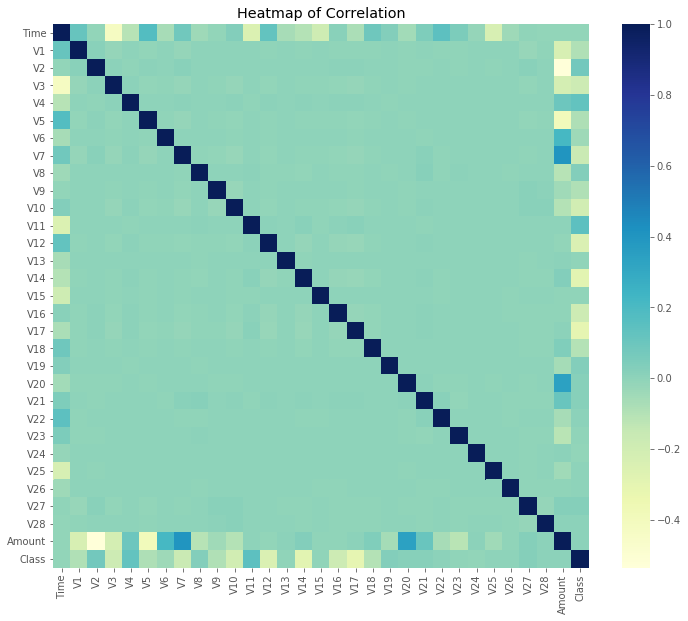

In [10]:
#heatmap
corr = data.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr, cmap="YlGnBu")
plt.title('Heatmap of Correlation')

## The amount and time attributes are not scaled with the rest of the features in the dataset. These can be scaled using standard scaler

In [11]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
amount = data['scaled_amount']
time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'amount', amount)
data.insert(1, 'time', time)

In [12]:
data.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.769551,-0.995569,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.267748,-0.995569,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.945369,-0.995557,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.407377,-0.995557,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.665419,-0.995545,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Sampling and redistributing dataset to avoid the class imbalance problem

In [13]:
data = data.sample(frac=1)

fraud_data = data.loc[data['Class']==1]
nfraud_data = data.loc[data['Class']==0][:460]

normal_distributed_df = pd.concat([fraud_data, nfraud_data])

# Shuffle dataframe rows
ndata = normal_distributed_df.sample(frac=1, random_state=42)

ndata.head()

,amount,time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
124036,1.483638,-0.088739,-0.715414,0.608590,1.155501,-0.267565,-0.563748,-0.618898,0.698308,0.069837,...,-0.186978,0.130749,0.239389,-0.090227,0.411572,-0.216126,0.353896,-0.062361,0.008433,1
167184,1.163200,0.397598,-5.961457,5.313382,-6.674320,6.028975,-1.387560,0.670638,-4.128987,-4.765894,...,-1.116581,5.556642,-1.501808,1.355172,0.141093,0.077913,0.473988,0.287129,1.468653,1
268951,-0.291181,0.925659,2.068061,0.099964,-2.039398,0.432775,0.683658,-0.326557,0.010965,-0.112997,...,-0.105374,-0.042188,0.209630,-0.105686,-1.087483,0.220164,0.680596,-0.040768,-0.049848,0
119781,1.421658,-0.107227,-2.866364,2.346949,-4.053307,3.983359,-3.463186,-1.280953,-4.474764,1.216655,...,0.270013,1.049732,0.475840,0.404480,0.282030,-0.506901,-0.371741,0.615257,0.803163,1
168052,-0.205768,0.403627,0.087581,0.900600,-0.545231,-0.735317,1.176487,-0.245830,0.821527,0.101169,...,0.037752,-0.305384,-0.788448,0.064623,0.109674,-0.423087,0.123024,0.216866,0.070457,0


Text(0.5, 1, 'Heatmap of Correlation')

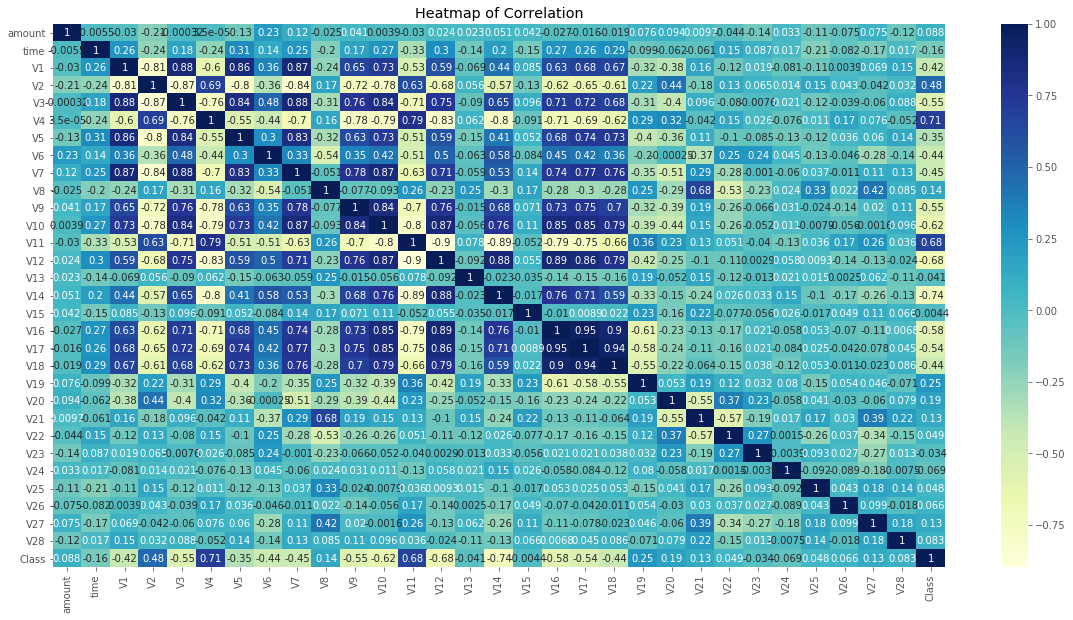

In [14]:
#heatmap
corr = ndata.corr()
plt.figure(figsize=(20,10))
heat = sns.heatmap(data=corr, cmap="YlGnBu", annot=True)
plt.title('Heatmap of Correlation')

# Train and test data split before model selection and fitting

In [15]:
X= ndata.iloc[:, ndata.columns != 'Class']
y = ndata.iloc[:, ndata.columns == 'Class']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Using Decision Tree Classifier

In [17]:
classifier = DecisionTreeClassifier(criterion = 'gini', random_state= 0 )
classifier.fit(X_train, y_train.ravel())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [18]:
y_pre = classifier.predict(X_test)

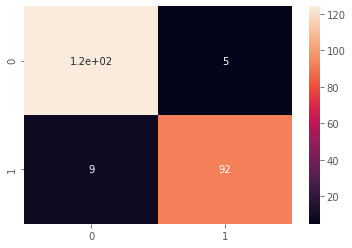

In [19]:
cm_grid = confusion_matrix(y_test,y_pre)
sns.heatmap(cm_grid, annot=True)

In [20]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       129
           1       0.95      0.91      0.93       101

    accuracy                           0.94       230
   macro avg       0.94      0.94      0.94       230
weighted avg       0.94      0.94      0.94       230



In [21]:
classifier.score(X_test,y_test)

0.9391304347826087

# Using Naive Bayes Classifier

In [22]:
classifier = GaussianNB()
classifier.fit(X_train, y_train.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [23]:
y_pre = classifier.predict(X_test)

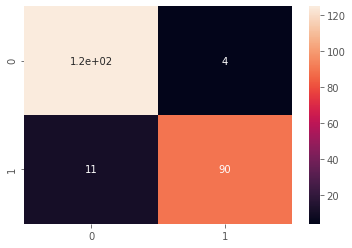

In [24]:
cm_grid = confusion_matrix(y_test,y_pre)
sns.heatmap(cm_grid, annot=True)

In [25]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       129
           1       0.96      0.89      0.92       101

    accuracy                           0.93       230
   macro avg       0.94      0.93      0.93       230
weighted avg       0.94      0.93      0.93       230



In [26]:
classifier.score(X_test,y_test)

0.9347826086956522

# Using Logistic Regression

In [27]:
classifier = LogisticRegression(solver='liblinear', random_state=0)
classifier.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_pre = classifier.predict(X_test)

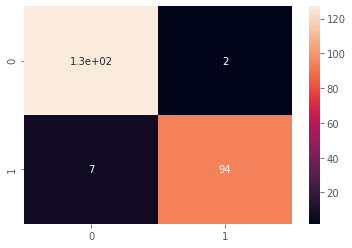

In [29]:
cm_grid = confusion_matrix(y_test,y_pre)
sns.heatmap(cm_grid, annot=True)

In [30]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       129
           1       0.98      0.93      0.95       101

    accuracy                           0.96       230
   macro avg       0.96      0.96      0.96       230
weighted avg       0.96      0.96      0.96       230



In [31]:
classifier.score(X_test,y_test)

0.9608695652173913

# Using XGBoost model 

In [ ]:
X= data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

X = np.array(X)
y = np.array(y)

model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y.ravel(), scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))